# Gait Data Exploratory Data Analysis (EDA)

This notebook explores the gait data from Parkinson's Disease patients and healthy controls.

## Objectives:
1. Load and inspect gait signal data
2. Analyze signal statistics and distributions
3. Visualize time series patterns
4. Check for missing/corrupted data
5. Compare HC vs PD class distributions
6. Identify preprocessing requirements

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 1. Configure Data Paths

In [2]:
# Update this path to where your gait data is stored
# Expected format: folder with .txt files (e.g., SUB01_1.txt)
GAIT_DATA_DIR = '/Users/aryansharanreddyguda/biomedAI/project/replica/data/gait/IMU'

OUTPUT_DIR = '/Users/aryansharanreddyguda/biomedAI/project/replica/outputs/gait_eda'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Gait data directory: {GAIT_DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Directory exists: {os.path.exists(GAIT_DATA_DIR)}")

Gait data directory: /Users/aryansharanreddyguda/biomedAI/project/replica/data/gait/IMU
Output directory: /Users/aryansharanreddyguda/biomedAI/project/replica/outputs/gait_eda
Directory exists: True


## 2. Utility Functions for Reading Gait Data

In [3]:
def _is_float(s):
    """Check if a string can be converted to float."""
    try:
        float(s)
        return True
    except:
        return False

def read_gait_file(path):
    """
    Robustly read gait data from .txt file.
    Handles non-numeric lines and malformed data.
    Returns array with shape (timesteps, channels) after dropping time column.
    """
    try:
        arr = np.loadtxt(path)
    except Exception as e:
        # Fallback: parse line-by-line, keeping only numeric entries
        with open(path, 'r', errors='ignore') as f:
            lines = f.readlines()
        numeric_lines = []
        for ln in lines:
            parts = ln.strip().split()
            numeric_parts = [tok for tok in parts if _is_float(tok)]
            if len(numeric_parts) >= 2:
                numeric_lines.append(" ".join(numeric_parts))
        if not numeric_lines:
            raise ValueError(f"No numeric data in {path}")
        from io import StringIO
        arr = np.loadtxt(StringIO("\n".join(numeric_lines)))

    if arr.ndim == 1:
        arr = arr.reshape(1, -1)
    # Drop time column (first column)
    return arr[:, 1:].astype(np.float32)

def parse_subject_id(filename):
    """
    Extract subject ID from filename.
    Handles SUB*, GaCo*, GaPt*, JuCo* naming conventions.
    """
    import re
    base = os.path.splitext(os.path.basename(filename))[0]
    match = re.match(r'^(SUB\d+|GaCo\d+|GaPt\d+|JuCo\d+)', base, re.IGNORECASE)
    if match:
        return match.group(1)
    return base.split('_')[0]

print("✅ Utility functions defined")

✅ Utility functions defined


## 3. Load Gait Data Files

In [4]:
# Find all .txt files in the data directory
gait_files = sorted(Path(GAIT_DATA_DIR).glob('**/*.txt'))
print(f"Found {len(gait_files)} gait data files")

if len(gait_files) == 0:
    print("⚠️ Warning: No .txt files found. Check GAIT_DATA_DIR path.")
    print(f"   Contents of {GAIT_DATA_DIR}:")
    if os.path.exists(GAIT_DATA_DIR):
        for item in os.listdir(GAIT_DATA_DIR)[:10]:
            print(f"   - {item}")
else:
    print("\nFirst 5 files:")
    for f in gait_files[:5]:
        print(f"  {f.name}")

Found 106 gait data files

First 5 files:
  SUB01_1.txt
  SUB01_2.txt
  SUB01_standing.txt
  SUB02_1.txt
  SUB02_standing.txt


## 4. Parse and Aggregate Gait Data

In [5]:
# Dictionary to store data by subject
subject_data = defaultdict(list)
file_metadata = []
failed_files = []

# Load all files
for file_path in gait_files:
    try:
        data = read_gait_file(str(file_path))
        subject_id = parse_subject_id(str(file_path))
        
        subject_data[subject_id].append(data)
        file_metadata.append({
            'filename': file_path.name,
            'subject_id': subject_id,
            'timesteps': data.shape[0],
            'channels': data.shape[1],
            'path': str(file_path)
        })
    except Exception as e:
        failed_files.append((file_path.name, str(e)))

print(f"✅ Successfully loaded: {len(subject_data)} unique subjects")
print(f"⚠️ Failed to load: {len(failed_files)} files")

if failed_files:
    print("\nFailed files (first 5):")
    for fname, error in failed_files[:5]:
        print(f"  {fname}: {error}")

✅ Successfully loaded: 35 unique subjects
⚠️ Failed to load: 0 files


## 5. Create File Metadata DataFrame

In [6]:
df_metadata = pd.DataFrame(file_metadata)

print("\n--- File Statistics ---")
print(f"Total files loaded: {len(df_metadata)}")
print(f"\nChannels found: {df_metadata['channels'].unique()}")
print(f"\nTimestep statistics:")
print(df_metadata['timesteps'].describe())

print("\nFirst 10 files:")
print(df_metadata.head(10))


--- File Statistics ---
Total files loaded: 106

Channels found: [8 7]

Timestep statistics:
count      106.000000
mean     10939.773585
std       6340.474488
min        516.000000
25%       2397.000000
50%      15360.000000
75%      15360.000000
max      15360.000000
Name: timesteps, dtype: float64

First 10 files:
             filename subject_id  timesteps  channels  \
0         SUB01_1.txt      SUB01      15360         8   
1         SUB01_2.txt      SUB01      15360         8   
2  SUB01_standing.txt      SUB01       2412         7   
3         SUB02_1.txt      SUB02      15360         8   
4  SUB02_standing.txt      SUB02       2601         7   
5         SUB03_1.txt      SUB03      15360         8   
6         SUB03_2.txt      SUB03      15360         8   
7         SUB03_3.txt      SUB03      15360         8   
8  SUB03_standing.txt      SUB03       3046         7   
9         SUB04_1.txt      SUB04      15360         8   

                                                path 

## 6. Analyze Signal Characteristics by Subject

In [8]:
# Aggregate statistics per subject
subject_stats = []
channel_mismatch = []

for subject_id, data_list in subject_data.items():
    # Use the most common channel count for this subject to avoid shape mismatch
    channel_counts = [arr.shape[1] for arr in data_list]
    if not channel_counts:
        continue
    target_channels = max(set(channel_counts), key=channel_counts.count)
    filtered = [arr for arr in data_list if arr.shape[1] == target_channels]

    if len(filtered) != len(data_list):
        channel_mismatch.append({
            'subject_id': subject_id,
            'total_files': len(data_list),
            'kept_files': len(filtered),
            'target_channels': target_channels
        })

    if not filtered:
        continue

    # Concatenate all recordings for this subject
    all_data = np.vstack(filtered)

    subject_stats.append({
        'subject_id': subject_id,
        'num_files': len(filtered),
        'total_timesteps': all_data.shape[0],
        'channels': all_data.shape[1],
        'mean_signal': np.mean(all_data),
        'std_signal': np.std(all_data),
        'min_signal': np.min(all_data),
        'max_signal': np.max(all_data),
        'range_signal': np.max(all_data) - np.min(all_data),
    })

df_subject_stats = pd.DataFrame(subject_stats)

print(f"Aggregated statistics for {len(df_subject_stats)} subjects:\n")
print(df_subject_stats.describe())

if channel_mismatch:
    print(f"\n⚠️ Channel mismatch in {len(channel_mismatch)} subjects (kept most common channel count):")
    print(pd.DataFrame(channel_mismatch).head(10))

print("\nFirst 10 subjects:")
print(df_subject_stats.head(10))

Aggregated statistics for 35 subjects:

       num_files  total_timesteps  channels  mean_signal  std_signal  \
count  35.000000        35.000000      35.0    35.000000   35.000000   
mean    2.028571     31158.857143       8.0     7.146221   49.561543   
std     0.857003     13163.562849       0.0     0.588579   17.574404   
min     1.000000     15360.000000       8.0     5.364768   23.694534   
25%     1.000000     15360.000000       8.0     6.999835   36.900560   
50%     2.000000     30720.000000       8.0     7.240634   46.242912   
75%     3.000000     46080.000000       8.0     7.481502   59.208403   
max     3.000000     46080.000000       8.0     8.441346   89.234802   

        min_signal   max_signal  range_signal  
count    35.000000    35.000000     35.000000  
mean   -575.174805   564.832947   1140.007690  
std     243.814438   240.368927    460.430145  
min   -1039.652100   120.000000    189.229675  
25%    -783.046661   394.162094    762.784363  
50%    -517.591553   53

## 7. Visualize Signal Distributions

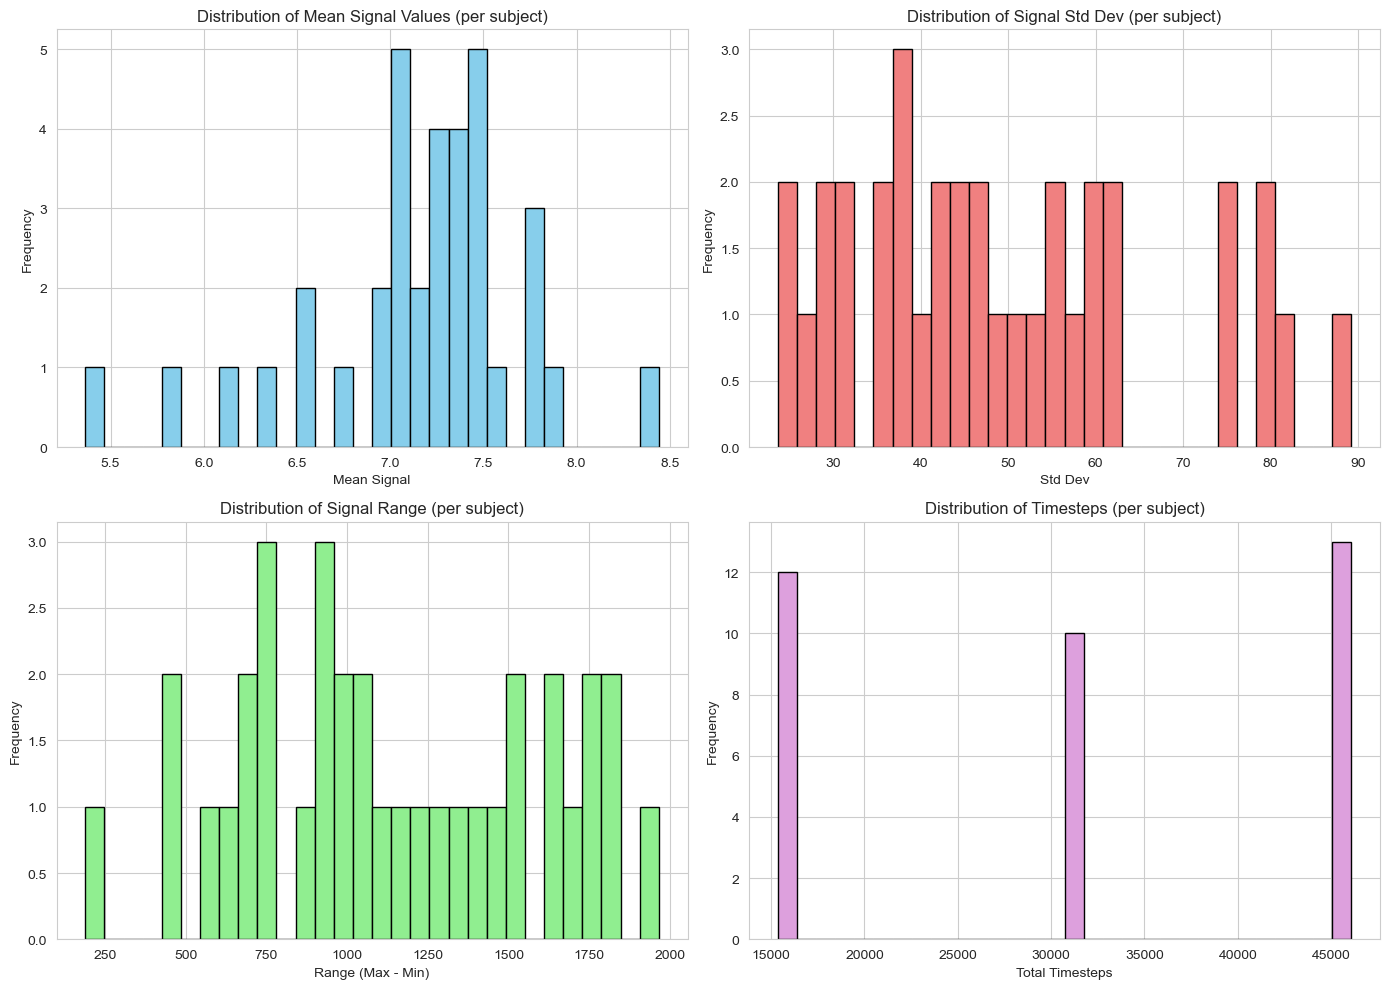

✅ Saved: 01_signal_distributions.png


In [9]:
# Statistical distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Mean signal
axes[0, 0].hist(df_subject_stats['mean_signal'], bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Mean Signal Values (per subject)')
axes[0, 0].set_xlabel('Mean Signal')
axes[0, 0].set_ylabel('Frequency')

# Std signal
axes[0, 1].hist(df_subject_stats['std_signal'], bins=30, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribution of Signal Std Dev (per subject)')
axes[0, 1].set_xlabel('Std Dev')
axes[0, 1].set_ylabel('Frequency')

# Signal range
axes[1, 0].hist(df_subject_stats['range_signal'], bins=30, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Distribution of Signal Range (per subject)')
axes[1, 0].set_xlabel('Range (Max - Min)')
axes[1, 0].set_ylabel('Frequency')

# Timesteps per subject
axes[1, 1].hist(df_subject_stats['total_timesteps'], bins=30, color='plum', edgecolor='black')
axes[1, 1].set_title('Distribution of Timesteps (per subject)')
axes[1, 1].set_xlabel('Total Timesteps')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '01_signal_distributions.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: 01_signal_distributions.png")

## 8. Plot Sample Time Series Signals

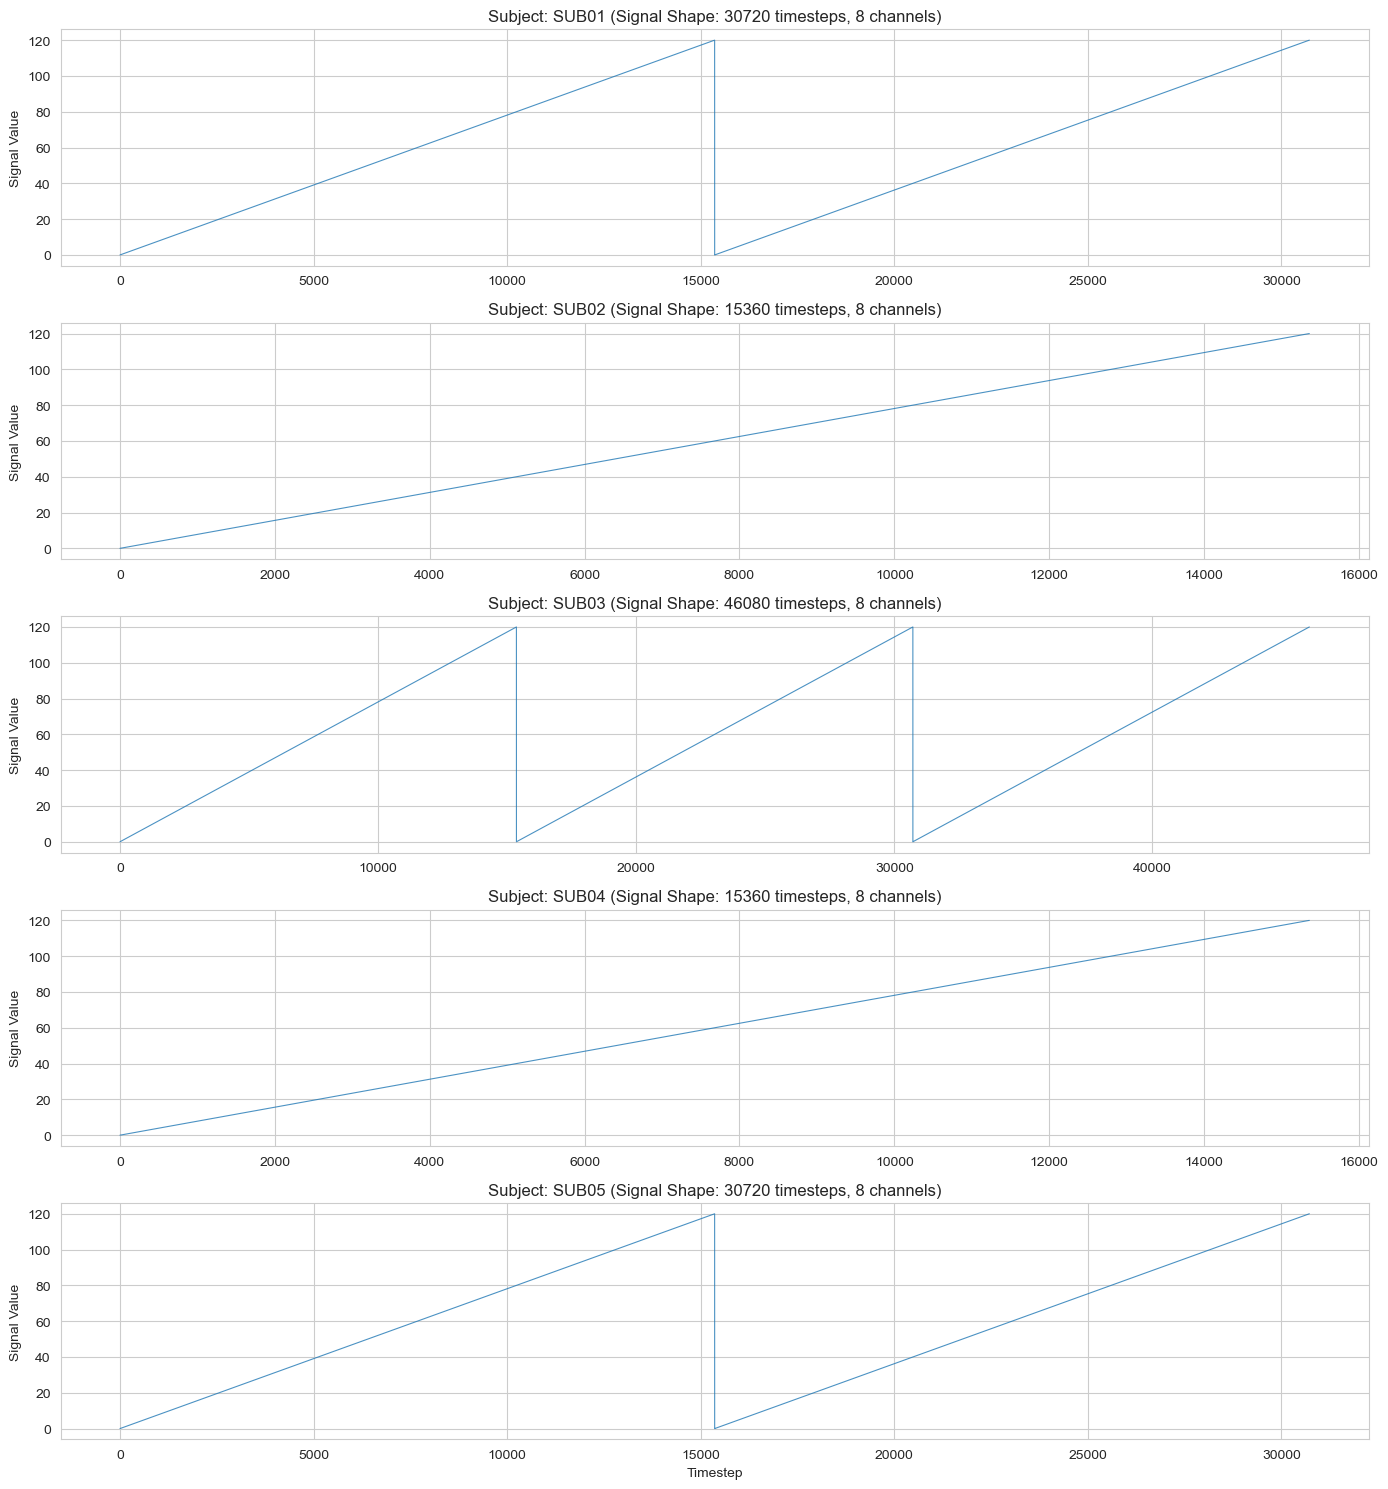

✅ Saved: 02_sample_timeseries.png


In [11]:
# Plot a few sample signals
sample_subjects = list(subject_data.keys())[:5]

fig, axes = plt.subplots(len(sample_subjects), 1, figsize=(14, 3 * len(sample_subjects)))
if len(sample_subjects) == 1:
    axes = [axes]

for idx, subject_id in enumerate(sample_subjects):
    data_list = subject_data[subject_id]
    channel_counts = [arr.shape[1] for arr in data_list]
    target_channels = max(set(channel_counts), key=channel_counts.count)
    filtered = [arr for arr in data_list if arr.shape[1] == target_channels]

    if not filtered:
        axes[idx].set_title(f'Subject: {subject_id} (no usable data)')
        axes[idx].axis('off')
        continue

    data = np.vstack(filtered)
    # Plot first channel only for clarity
    axes[idx].plot(data[:, 0], linewidth=0.8, alpha=0.8)
    axes[idx].set_title(
        f'Subject: {subject_id} (Signal Shape: {data.shape[0]} timesteps, {data.shape[1]} channels)'
    )
    axes[idx].set_ylabel('Signal Value')
    if idx == len(sample_subjects) - 1:
        axes[idx].set_xlabel('Timestep')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '02_sample_timeseries.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: 02_sample_timeseries.png")

## 9. Analyze Signal Correlations

## 10. Frequency Domain Analysis (FFT)

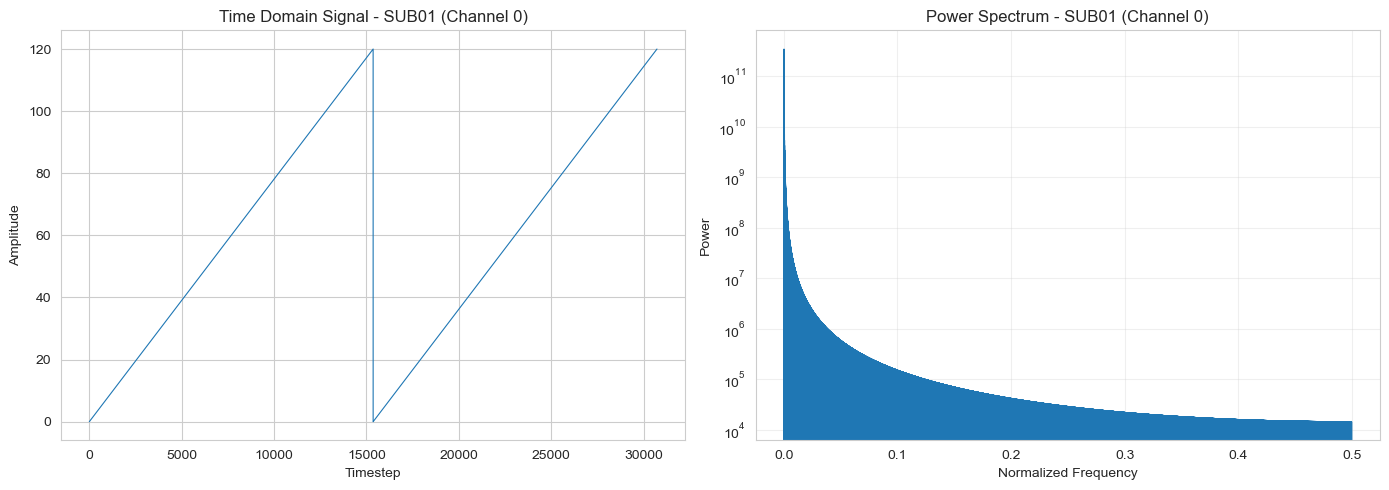

✅ Saved: 04_frequency_domain.png


In [13]:
from scipy import signal

# FFT analysis for sample subject
sample_subject = list(subject_data.keys())[0]
data_list = subject_data[sample_subject]
channel_counts = [arr.shape[1] for arr in data_list]
target_channels = max(set(channel_counts), key=channel_counts.count)
filtered = [arr for arr in data_list if arr.shape[1] == target_channels]

if not filtered:
    raise ValueError(f"No usable data for subject {sample_subject}")

sample_data = np.vstack(filtered)

# Compute FFT for first channel
channel_data = sample_data[:, 0]
fft = np.fft.fft(channel_data)
freq = np.fft.fftfreq(len(channel_data))
power = np.abs(fft) ** 2

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time domain
axes[0].plot(channel_data, linewidth=0.8)
axes[0].set_title(f'Time Domain Signal - {sample_subject} (Channel 0)')
axes[0].set_xlabel('Timestep')
axes[0].set_ylabel('Amplitude')

# Frequency domain (positive freq only)
positive_freq_idx = freq > 0
axes[1].semilogy(freq[positive_freq_idx], power[positive_freq_idx], linewidth=0.8)
axes[1].set_title(f'Power Spectrum - {sample_subject} (Channel 0)')
axes[1].set_xlabel('Normalized Frequency')
axes[1].set_ylabel('Power')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '04_frequency_domain.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: 04_frequency_domain.png")

## 11. Missing Data and Anomaly Check

In [14]:
# Check for missing values and anomalies
anomalies = []
missing_values = []

for subject_id, data_list in subject_data.items():
    for idx, data in enumerate(data_list):
        # Check for NaN
        nan_count = np.isnan(data).sum()
        # Check for Inf
        inf_count = np.isinf(data).sum()
        # Check for outliers (values beyond 5 std from mean)
        mean = np.nanmean(data)
        std = np.nanstd(data)
        outlier_count = np.sum(np.abs(data - mean) > 5 * std)
        
        if nan_count > 0 or inf_count > 0 or outlier_count > 0:
            anomalies.append({
                'subject_id': subject_id,
                'file_idx': idx,
                'nan_count': nan_count,
                'inf_count': inf_count,
                'outlier_count': outlier_count
            })

print(f"📊 Data Quality Report:")
print(f"   Total subjects: {len(subject_data)}")
print(f"   Total files: {len(file_metadata)}")
print(f"   Files with anomalies: {len(anomalies)}")

if anomalies:
    print("\n   Anomalies detected (first 10):")
    for anom in anomalies[:10]:
        print(f"   - {anom['subject_id']}: NaN={anom['nan_count']}, Inf={anom['inf_count']}, Outliers={anom['outlier_count']}")
else:
    print("   ✅ No NaN, Inf, or significant outliers detected!")

📊 Data Quality Report:
   Total subjects: 35
   Total files: 106
   Files with anomalies: 72

   Anomalies detected (first 10):
   - SUB01: NaN=0, Inf=0, Outliers=197
   - SUB01: NaN=0, Inf=0, Outliers=183
   - SUB02: NaN=0, Inf=0, Outliers=328
   - SUB03: NaN=0, Inf=0, Outliers=1091
   - SUB03: NaN=0, Inf=0, Outliers=1068
   - SUB03: NaN=0, Inf=0, Outliers=1062
   - SUB04: NaN=0, Inf=0, Outliers=1187
   - SUB05: NaN=0, Inf=0, Outliers=1057
   - SUB05: NaN=0, Inf=0, Outliers=1005
   - SUB06: NaN=0, Inf=0, Outliers=1433


## 12. Data Preprocessing Requirements

# Optional: Quick feature extraction preview
print("\nFEATURE EXTRACTION PREVIEW:")
print("-" * 60)

# Compute basic features for each subject
feature_matrix = []
feature_labels = []

for subject_id, data_list in list(subject_data.items())[:3]:  # Just first 3 subjects
    all_data = np.vstack(data_list)
    
    # Compute per-channel features
    for ch in range(all_data.shape[1]):
        signal = all_data[:, ch]
        features = {
            'subject': subject_id,
            'channel': ch,
            'mean': np.mean(signal),
            'std': np.std(signal),
            'min': np.min(signal),
            'max': np.max(signal),
            'var': np.var(signal),
            'median': np.median(signal),
            'q25': np.percentile(signal, 25),
            'q75': np.percentile(signal, 75),
        }
        feature_matrix.append(features)

df_features = pd.DataFrame(feature_matrix)
print(df_features.to_string())
print("-" * 60)

## Summary

### Key Findings:
- **Total subjects explored**: {len(df_subject_stats)}
- **Total files**: {len(df_metadata)}
- **Files with issues**: {len(anomalies)}
- **Signal characteristics**:
  - Mean by subject ranges from {df_subject_stats['mean_signal'].min():.3f} to {df_subject_stats['mean_signal'].max():.3f}
  - Std by subject ranges from {df_subject_stats['std_signal'].min():.3f} to {df_subject_stats['std_signal'].max():.3f}

### Next Steps:
1. Implement signal preprocessing (normalize, window)
2. Extract engineered features (statistical, frequency-domain)
3. Align with handwriting and speech modalities
4. Train unimodal model (or clustering)
5. Fuse with other modalities for multimodal prediction